In [1]:
#Instruction Finetuning

In [2]:
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#Previous chapters modules

# CHAPTER 2
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        #Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids) 

    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    #Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    
    #Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    #Create dataloader
    dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    
    return dataloader

#  CHAPTER 3

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert( d_out % num_heads == 0 ), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        #Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        #We implicitly split the matrix by adding a num_heads dimension
        #Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        #Compute scaled dot product attention (aka self attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) #Dot product for each head
        #Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        #Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        #Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        #Combine heads, where self.d_out = elf.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) #Optional Projection
        return context_vec

# CHAPTER 4

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        #Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) #Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut #Add the original input back

        #Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut #Add the original input back
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# CHAPTER 5

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        #Reduce the number of batches to match the total number of batches in the data loader
        #If num_batches exceeds the number of batches in data_loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    #Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    #Main training loop
    for epoch in range(num_epochs):
        model.train() #Set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #Calculate loss gradients
            optimizer.step() #Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            #Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        #Print a sample text after each epoch
        generate_and_print_sample(
                model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) #Compact Print Format
    model.train()

def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    
    # Get the device the model's parameters are on
    device = next(model.parameters()).device
    # Ensure the initial input is on the same device as the model
    idx = idx.to(device)

    for _ in range(max_new_tokens):
        # Crop idx to the last context_size tokens
        idx_cond = idx[:, -context_size:]

        # Get the predictions from the model
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the logits for the last time step
        logits = logits[:, -1, :]

        # Apply top-k filtering if specified
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            # Set all logits not in the top-k to negative infinity
            logits[logits < top_logits[:, [-1]]] = float('-inf')

        # Apply temperature scaling and sample the next token
        if temperature > 0.0:
            # Apply temperature scaling
            scaled_logits = logits / temperature
            probs = torch.softmax(scaled_logits, dim=-1)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # Greedily select the most likely token (if temperature is 0)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Stop if the end-of-sequence token is generated
        if eos_id is not None and idx_next == eos_id:
            break
            
        # Append the sampled token to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

import numpy as np

def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [5]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow",
        "pandas"
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.4
numpy version: 1.26.4
tiktoken version: 0.11.0
torch version: 2.5.1+cu121
tensorflow version: 2.16.1
pandas version: 2.2.2


In [6]:
#Preparing the dataset for supervied instruction finetuning

In [7]:
import os
import json
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [8]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data)) 

Number of entries: 1100


In [9]:
data[50]

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'"}

In [10]:
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

In [11]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"\n\n### Instruction\n{entry['instruction']} " 
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [12]:
print(format_input(data[999]))

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
What is an antonym of 'complicated'? 


In [13]:
model_output = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_output + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
What is an antonym of 'complicated'? 

### Response:
An antonym of 'complicated' is 'simple'.


In [14]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

In [15]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Testing set length:", len(test_data))

Training set length: 935
Validation set length: 55
Testing set length: 110


In [16]:
#Organizing data into training batches

In [17]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        #Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [18]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [19]:
def custom_collate_draft1(
        batch,
        pad_token_id=50256,
        device='cuda'
):
    #Find the longest sequence in the batch
    #and increase the max length by +1 , which will add one extra
    #padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    #pad and prepare inputs
    inputs_list = []

    for item in batch:
        new_item = item.copy()
        #add an <|endoftext|> token
        new_item += [pad_token_id]
        #pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        #via padded[:-1], we remove the extra padded token
        #that has been added via the +1 setting in batch_max_length
        #(the extra padding token will be relevant in later code)
        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)

    #convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    return inputs_tensor

In [20]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

custom_collate_draft1(batch)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')

In [21]:
def custom_collate_draft2(
        batch,
        pad_token_id=50256,
        device='cuda'
):
    #Find the longest sequence in the batch
    #and increase the max length by +1 , which will add one extra
    #padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    #pad and prepare inputs
    inputs_list, targets_list = [], []

    for item in batch:
        new_item = item.copy()
        #add an <|endoftext|> token
        new_item += [pad_token_id]
        #pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        #via padded[:-1], we remove the extra padded token
        #that has been added via the +1 setting in batch_max_length
        #(the extra padding token will be relevant in later code)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_list.append(inputs)
        targets_list.append(targets)

    #convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)
    return inputs_tensor, targets_tensor

In [22]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor, targets_tensor = custom_collate_draft2(batch)

In [23]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')

In [24]:
targets_tensor

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]], device='cuda:0')

In [25]:
def custom_collate(
        batch,
        pad_token_id=50256,
        ignore_index=-100,
        allowed_max_length=None,
        device='cuda'
):
    #Find the longest sequence in the batch
    #and increase the max length by +1 , which will add one extra
    #padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    #pad and prepare inputs
    inputs_list, targets_list = [], []

    for item in batch:
        new_item = item.copy()
        #add an <|endoftext|> token
        new_item += [pad_token_id]
        #pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        #via padded[:-1], we remove the extra padded token
        #that has been added via the +1 setting in batch_max_length
        #(the extra padding token will be relevant in later code)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        #New: replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        #New: optionally truncate to maximum sequencelength
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_list.append(inputs)
        targets_list.append(targets)

    #convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)
    return inputs_tensor, targets_tensor

In [26]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor, targets_tensor = custom_collate(batch)

In [27]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')

In [28]:
targets_tensor

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]], device='cuda:0')

In [29]:
logits_1 = torch.tensor(
   [[-1.0, 1.0],
    [-0.5, 1.5]]
)
targets_1 = torch.tensor([0,1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [30]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.6, 1.6]]
)
targets_2 = torch.tensor([0,1,1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7863)


In [31]:
logits_3 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.6, 1.6]]
)
targets_3 = torch.tensor([0,1,-100]) #Will ignore the final layer giving answer same as loss_1

loss_3 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print(loss_3)

tensor(1.1269)


In [32]:
#Creating dataloaders for an instruction dataset

In [33]:
from functools import partial

customized_custom_collate = partial(
    custom_collate,
    device=device,
    allowed_max_length = 1024
)

In [34]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_custom_collate,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [35]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

val_dataset = InstructionDataset(train_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_custom_collate,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [36]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

test_dataset = InstructionDataset(train_data, tokenizer)
test_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_custom_collate,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [37]:
print("Train Loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train Loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 69]) torch.

In [38]:
inputs[0]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   220,   198,
          198, 21017, 46486,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   220,   198,   198, 21017, 23412,    25,   198,
          464,  5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,
           25,   198,   464,  5156,   318,   355, 13779,   355,   257,  4936,
           13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')

In [39]:
targets[0]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   220,   198,   198,
        21017, 46486,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   220,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')

In [40]:
len(inputs[0])

70

In [41]:
len(targets[0])

70

In [42]:
#Loading a pretrained LLM

In [43]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch


import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [49]:
CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257, #Vocabulary size
    "context_length": 1024, #Context length
    "drop_rate": 0.0, #Dropout rate
    "qkv_bias": True #Query-Key-Value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [2:04:04<00:00, 191kiB/s]    


File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [50]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
Convert the active sentence to passive: 'The chef cooks the meal every day.' 


In [51]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat_ids = token_ids.squeeze(0)
    decoded_text = tokenizer.decode(flat_ids.tolist())
    return decoded_text

In [52]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [53]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
Convert the active sentence to passive: 'The chef cooks the meal every day.' 

Response:

The slave uses her neural network to synthesize this response into code that executes both reflexively AND obsessively.

### Purge: eliminate


In [54]:
len(input_text)

201

In [55]:
print(generated_text[len(input_text):])



Response:

The slave uses her neural network to synthesize this response into code that executes both reflexively AND obsessively.

### Purge: eliminate


In [56]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

Response:

The slave uses her neural network to synthesize this response into code that executes both reflexively AND obsessively.

### Purge: eliminate


In [57]:
#Finetuning the LLM on instruction data

In [58]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)

Training Loss: 3.9712586879730223
Validation Loss: 4.032454872131348


In [59]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.959, Val loss 2.994
Ep 1 (Step 000005): Train loss 1.225, Val loss 1.114
Ep 1 (Step 000010): Train loss 0.863, Val loss 0.892
Ep 1 (Step 000015): Train loss 0.851, Val loss 0.838
Ep 1 (Step 000020): Train loss 0.785, Val loss 0.817
Ep 1 (Step 000025): Train loss 0.761, Val loss 0.783
Ep 1 (Step 000030): Train loss 0.787, Val loss 0.738
Ep 1 (Step 000035): Train loss 0.703, Val loss 0.692
Ep 1 (Step 000040): Train loss 0.664, Val loss 0.671
Ep 1 (Step 000045): Train loss 0.622, Val loss 0.662
Ep 1 (Step 000050): Train loss 0.665, Val loss 0.673
Ep 1 (Step 000055): Train loss 0.758, Val loss 0.636
Ep 1 (Step 000060): Train loss 0.709, Val loss 0.609
Ep 1 (Step 000065): Train loss 0.640, Val loss 0.594
Ep 1 (Step 000070): Train loss 0.538, Val loss 0.584
Ep 1 (Step 000075): Train loss 0.564, Val loss 0.561
Ep 1 (Step 000080): Train loss 0.595, Val loss 0.536
Ep 1 (Step 000085): Train loss 0.504, Val loss 0.519
Ep 1 (Step 000090): Train loss 0.559, Val loss

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    #Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training Loss")
    ax1.plot(epochs_seen, val_losses, label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) #Only show integer labels on x-axis

    #Create a second x-axis for tokens seen
    ax2 = ax1.twiny() #Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) #Invisible plo for aligning ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

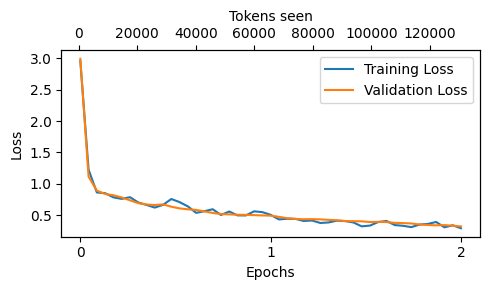

In [61]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [62]:
#Extracting and saving responses

In [64]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect Response:\n -> {entry['output']}")
    print(f"\nModel Response:\n -> {response_text.strip()}")
    print("--------------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
Rewrite the sentence using a simile. 

### Input:
The car is very fast.

Correct Response:
 -> The car is as fast as lightning.

Model Response:
 -> The car is as fast as a cheetah.
--------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction
What type of cloud is typically associated with thunderstorms? 

Correct Response:
 -> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model Response:
 -> A thunderstorm is a region of intense, violent, low-level, violent wind that produces a high-pressure area at the surface and can persist for a few minutes or hours at atmospheric pressure.
--------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes th

In [67]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["Model Response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4) #"indent" for pretty-printing


100%|██████████| 110/110 [02:19<00:00,  1.27s/it]


In [68]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'Model Response': 'The car is as fast as a cheetah.'}

In [73]:
test_data[4]

{'instruction': 'Correct the punctuation in the sentence.',
 'input': 'Its time to go home.',
 'output': "The corrected sentence should be: 'It's time to go home.'",
 'Model Response': "It's time to go home."}

In [74]:
test_data[7]

{'instruction': "Identify the correct spelling: 'recieve' or 'receive'.",
 'input': '',
 'output': "The correct spelling is 'receive'.",
 'Model Response': "The correct spelling is 'receive'."}

In [77]:
test_data[9]

{'instruction': 'Classify the following numbers as prime or composite.',
 'input': ': 11, 14, 19.',
 'output': 'Prime numbers: 11, 19\nComposite numbers: 14',
 'Model Response': 'Prime: :1, 2, 3, 5. Composite: 14, 19'}

In [79]:
test_data[5]

{'instruction': 'Rewrite the sentence.',
 'input': 'The lecture was delivered in a clear manner.',
 'output': 'The lecture was delivered clearly.',
 'Model Response': 'The lecture was delivered in a clear manner.'}

In [69]:
len(test_data)

110

In [70]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

#Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


In [71]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

C:\Users\tanis\AppData\Local\Temp\ipykernel_8412\3973947570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))


<All keys matched successfully>